In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electron-microscopy-particle-segmentation/segmaps/00655d9628.png
/kaggle/input/electron-microscopy-particle-segmentation/segmaps/1bed563906.png
/kaggle/input/electron-microscopy-particle-segmentation/segmaps/2bc87a8698.png
/kaggle/input/electron-microscopy-particle-segmentation/segmaps/1b935635dd.png
/kaggle/input/electron-microscopy-particle-segmentation/segmaps/f7fa7d1729.png
/kaggle/input/electron-microscopy-particle-segmentation/segmaps/ed3a3cb76b.png
/kaggle/input/electron-microscopy-particle-segmentation/segmaps/dcfbfa74e4.png
/kaggle/input/electron-microscopy-particle-segmentation/segmaps/0144266d21.png
/kaggle/input/electron-microscopy-particle-segmentation/segmaps/6643f01cf4.png
/kaggle/input/electron-microscopy-particle-segmentation/segmaps/245e1a4826.png
/kaggle/input/electron-microscopy-particle-segmentation/segmaps/39e18a8f4c.png
/kaggle/input/electron-microscopy-particle-segmentation/segmaps/2d1a6c5ce4.png
/kaggle/input/electron-microscopy-particle-segmentat

In [2]:
import torch
import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

import matplotlib.pyplot as plt
import seaborn as sn

# Support libraries
import numpy as np
import pandas as pd
import itertools
import os
import random
from PIL import Image

In [3]:
class ParticleSeg(Dataset):
    
    def __init__(self, root_dir:str, img_transforms:object=None, mask_transforms:object=None):
        
        super().__init__()
        
        self.root_dir = root_dir
        self.transforms_mask = mask_transforms
        self.transforms_img = img_transforms
        
        self.mask_dir = os.path.join(root_dir, "segmaps")
        self.img_dir = os.path.join(root_dir, "images")
        
        self.file_names = os.listdir(self.mask_dir)
        self.mask_paths = [os.path.join(self.mask_dir, mask_name) for mask_name in self.file_names]
        self.img_paths = [os.path.join(self.img_dir, img_name) for img_name in self.file_names]
   

    def __len__(self):
        
        return len(self.file_names)

    def __getitem__(self, ix:int):

        seed = np.random.randint(2022)
        random.seed(seed)
        torch.manual_seed(seed)

        mask_path, img_path = self.mask_paths[ix], self.img_paths[ix]

        mask, img = Image.open(mask_path), Image.open(img_path).convert('RGB')

        if self.transforms_img is not None:

            img = self.transforms_img(img)

        random.seed(seed)
        torch.manual_seed(seed)

        if self.transforms_mask is not None:

            mask = self.transforms_mask(mask)

        mask, img = mask.float(), img.float()
        
        mask[mask > 0 ] = 1
#         img = img / 255

        return img, mask

In [4]:
img_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Resize((244,244)),
])
mask_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((244,244))
])

In [5]:
dataset = ParticleSeg(
    root_dir='/kaggle/input/electron-microscopy-particle-segmentation', 
    img_transforms=img_transforms,
    mask_transforms=mask_transforms
)

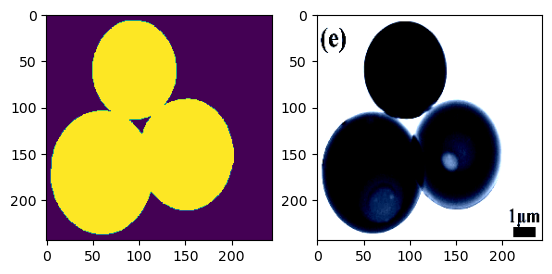

In [6]:
mask, img = dataset[10]

fig, ax = plt.subplots(nrows=1, ncols=2)

pos1 = ax[0].imshow(img.permute((1, 2, 0)))
pos2 = ax[1].imshow(mask.permute((1, 2, 0)))

In [7]:
dataset_train, dataset_val = random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])

print(len(dataset_train), len(dataset_val))

372 93


In [8]:
dataloader_train = DataLoader(dataset_train, batch_size = 16)
dataloader_val = DataLoader(dataset_val, batch_size = 16)

In [9]:
def createDeepLabv3(outputchannels=1):
    model = models.segmentation.deeplabv3_resnet50(pretrained=True,
                                                    progress=True)
    model.classifier = DeepLabHead(2048, outputchannels)
    return model

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = createDeepLabv3(1).to(device)
criterion =  nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 50

def train(model, dataloader):
    model.train()
    train_loss = 0
    for data in dataloader:
        optimizer.zero_grad()
        
        images, masks = data[0].to(device), data[1].to(device)
        out = model(images)['out']
        
        loss = criterion(out, masks)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss/ len(dataloader)

def test(model, dataloader):
    model.eval()
    test_loss = 0
    for data in dataloader:        
        images, masks = data[0].to(device), data[1].to(device)
        out = model(images)['out']
        
        loss = criterion(out, masks)
        test_loss += loss.item()

    return test_loss/ len(dataloader)

for epoch in range(epochs):
    train_loss = train(model, dataloader_train)
    test_loss = test(model, dataloader_val)
    print('Epoch [{}/{}], Train loss: {:.4f}, Val loss {:.4f}'.format(epoch+1, epochs, train_loss, test_loss))


/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

Epoch [1/50], Train loss: 0.5667, Val loss 0.6162
Epoch [2/50], Train loss: 0.3694, Val loss 0.4095
Epoch [3/50], Train loss: 0.2842, Val loss 0.3271
Epoch [4/50], Train loss: 0.2395, Val loss 0.2922
Epoch [5/50], Train loss: 0.2107, Val loss 0.2697
Epoch [6/50], Train loss: 0.1906, Val loss 0.2525
Epoch [7/50], Train loss: 0.1755, Val loss 0.2396
Epoch [8/50], Train loss: 0.1639, Val loss 0.2293
Epoch [9/50], Train loss: 0.1546, Val loss 0.2208
Epoch [10/50], Train loss: 0.1465, Val loss 0.2137
Epoch [11/50], Train loss: 0.1405, Val loss 0.2076
Epoch [12/50], Train loss: 0.1347, Val loss 0.2021
Epoch [13/50], Train loss: 0.1299, Val loss 0.1976
Epoch [14/50], Train loss: 0.1256, Val loss 0.1934
Epoch [15/50], Train loss: 0.1218, Val loss 0.1899
Epoch [16/50], Train loss: 0.1184, Val loss 0.1867
Epoch [17/50], Train loss: 0.1155, Val loss 0.1837
Epoch [18/50], Train loss: 0.1125, Val loss 0.1807
Epoch [19/50], Train loss: 0.1101, Val loss 0.1784
Epoch [20/50], Train loss: 0.1075, Val l

In [11]:
dataiter = iter(dataloader_train)
images, masks = next(dataiter)

images = images.to(device)
output = model(images)['out']

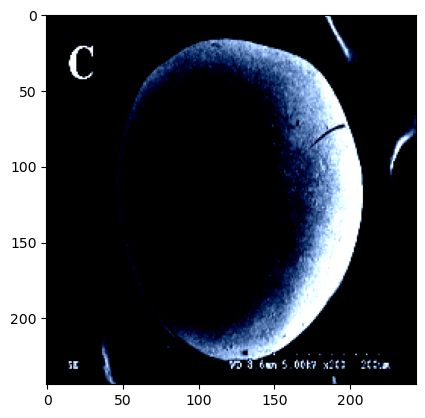

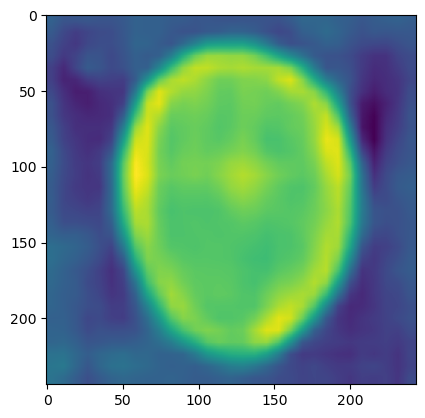

In [12]:
plt.imshow(images[15].cpu().permute((1, 2, 0)))
plt.show()
plt.imshow(output[15].cpu().detach().permute((1, 2, 0)))